In [1]:
import pandas as pd
import folium as f
import os
import glob
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import datetime
import random
import numpy as np
from haversine import haversine
from sklearn.cluster import DBSCAN
import itertools
from tqdm import tqdm
import random

In [2]:
all_csv = glob('/STORAGE/DATA/01_KRISO_G_MAPPED_DATA/Position_LTEM/*.csv')
all_csv = sorted(all_csv)
selected_csv = all_csv[0:25]

total = pd.DataFrame()

for sel in tqdm(selected_csv):
    temp = pd.read_csv(sel, sep = ',', encoding='utf-8')
    total = pd.concat([total, temp])
    
total.reset_index(inplace = True, drop = True)

print('Data Load END.')

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.11it/s]

Data Load END.


In [11]:
'''
BCD 선박
'''
A_ship_idx = total[total.SHIP_CODE.str.startswith('A')].index
# U_ship_idx = total[total.SHIP_CODE.str.startswith('U')].index

except_A = total.drop(A_ship_idx)
# except_A = except_A.drop(U_ship_idx)

except_A.reset_index(inplace = True, drop = True)

# 첫 글자 부여 tooltip 을 위함
except_A['SHIP_Category'] = except_A['SHIP_CODE'].apply(lambda x: x[0][0])

except_A_dict = {}

bcd_ship_code= except_A.SHIP_CODE.unique()

for ship in tqdm(bcd_ship_code):
    value  = except_A[except_A.SHIP_CODE.values == ship]
    except_A_dict[ship] = value
print('Except A_ship matching in Dictionary END')

100%|█████████████████████████████████████████████████████████████████████████████| 1808/1808 [02:41<00:00, 11.23it/s]

Except A_ship matching in Dictionary END


In [13]:
# SOG >= 2 Data frame 
def upper_2_dataframe(df):
    # Dict.values 안에 있는 dataframe -> list
    dict_to_lst = []
    
    for df in tqdm(df.values()):
        dict_to_lst.append(df[df.dSOG.values >=2])
    
    # SOG <2 제외 하고 데이터 프레임 갱신
    not_empty_df = [full for full in dict_to_lst if not full.empty]
    
    return not_empty_df
print('SOG upper 2 END')

SOG upper 2 END


In [14]:
# 시간을 보기좋게 전처리 (tooltip)
def reset_index_time_series(df):
    for i in range(len(df)):
        time_int = df[i].szMsgSendDT.values.tolist()
        time_str = []
        timestamp_ = []

        for j in range(len(time_int)):
            time_str.append(str(time_int[j]))
        # 시간 정보를 보기 좋게 바꿔준다
        for str_ in time_str:
            n = datetime.datetime.strptime(str_,"%Y%m%d%H%M%S%f")
            timestamp_.append(n.strftime("%Y-%m-%d-%H-%M-%S"))
        df[i]['szMsgSendDT'] = timestamp_
        
        time_str.clear()
        timestamp_.clear()

    return df

In [15]:
'''
A 제외 선박 딕셔너리화
'''
upper_2 = upper_2_dataframe(except_A_dict)
reset_time = reset_index_time_series(upper_2)

100%|███████████████████████████████████████████████████████████████████████████| 1808/1808 [00:00<00:00, 9715.89it/s]
/tmp/ipykernel_1176060/1107519549.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# 최종 전처리 셋 : 모든 A 선박, 하나의 DATAFRAME 으로 저장 
final_preprocessing  = pd.DataFrame()

for except_A_ship_df in reset_time:
    final_preprocessing = pd.concat([final_preprocessing, except_A_ship_df])
    
final_preprocessing.reset_index(inplace = True, drop = True)

final_preprocessing

szMsgSendDT SHIP_CODE      dSOG   dCOG       dLat  \
0        2022-06-28-11-06-54  BE010da2  6.331898  149.0  36.965206   
1        2022-06-28-11-07-01  BE010da2  6.413284  143.0  36.965038   
2        2022-06-28-11-07-04  BE010da2  6.368347  144.0  36.964966   
3        2022-06-28-11-07-07  BE010da2  6.204031  145.0  36.964893   
4        2022-06-28-11-07-13  BE010da2  6.056499  144.0  36.964756   
...                      ...       ...       ...    ...        ...   
2332991  2022-06-29-11-49-59  AB09094c  3.255018   30.0  34.470524   
2332992  2022-06-29-11-50-03  AB09094c  3.297738   28.0  34.470577   
2332993  2022-06-29-11-50-07  AB09094c  3.246699   11.0  34.470634   
2332994  2022-06-29-11-50-12  AB09094c  2.548365   15.0  34.470699   
2332995  2022-06-29-11-50-15  AB09094c  2.151500   14.0  34.470734   

               dLon SHIP_Category  
0        126.828316             B  
1        126.828484             B  
2        126.828552             B  
3        126.828613             B  
4        126.828751             B  
...             ...           ...  
2332991  127.296349             A  
2332992  127.296387             A  
2332993  127.296402             A  
2332994  127.296432             A  
2332995  127.296448             A  

[2332996 rows x 7 columns]

In [ ]:
'''
Folium
'''
def folium(df):
    m = f.Map(location = [df.dLat[0], df.dLon[0]])    
    
    lat = df.dLat.tolist()
    lon = df.dLon.tolist()
    
    for lat_, lon_ in zip(lat, lon):
        f.CircleMarker(location = [lat_, lon_], radius = 3, color = 'SHIP_CODE').add_to(m)
        
    return m

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
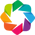

In [10]:
'''
Datashader
'''
import holoviews as hv, colorcet as cc
import datashader as ds
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

'''
밑에 있는 3줄 짜리는 최초 실행 한번만 하고
두번째 실행 부터는 실행 시키면 안된다.
밑에 세줄짜리 코드가 넘파이로 뭐 벡터화 시켜서 
경도, 위도를 웹머케이터 좌표계로 좌표 변환 한다는데 얘는 한번만 해놓으면 된다고 한다. 두번째 부터는 또 변환되기 때문에 오류남
'''
x,y = ds.utils.lnglat_to_meters(final_preprocessing.dLon, final_preprocessing.dLat)
final_preprocessing['dLon'] = x
final_preprocessing['dLat'] = y

map_tiles = hv.element.tiles.EsriImagery().opts(alpha=0.5, width=600, height=600)

points = hv.Points(final_preprocessing, ['dLon', 'dLat'])

ship_traffic = datashade(points, cmap= 'magma', width=600, height=600, x_sampling=1, y_sampling=1)
datashade_visualization = map_tiles * ship_traffic
hv.save(datashade_visualization, 'A제외 선박전체 datashade.html')

#datashade_visualization


In [17]:
'''
Plotly
'''
import plotly.express as px
import plotly.offline as pyo

fig = px.line_mapbox(final_preprocessing, lat = "dLat", lon = "dLon", color = 'SHIP_Category', zoom =3, height=900)

# 지도 배경 layout 토큰
fig.update_layout(mapbox=dict(
    accesstoken='pk.eyJ1IjoibGFnb29uNiIsImEiOiJjbGd4M2gycmkwM3VzM3JscGQ0YzlxYjU1In0.CBy01IB-Z8klhIcFRnkXKg',
    zoom=3
))
    
pyo.plot(fig, filename = 'A,U 제외 선박 전체동선(전처리 전).html')

'A,U 제외 선박 전체동선(전처리 전).html'

# -------------------   C D SHIP Random sample --------------------------

In [15]:
uniq_c = final_preprocessing[final_preprocessing.SHIP_CODE.str.startswith('C')].SHIP_CODE.unique().tolist()
uniq_d = final_preprocessing[final_preprocessing.SHIP_CODE.str.startswith('D')].SHIP_CODE.unique().tolist()

choice_c_list = random.sample(uniq_c, 30)
choice_d_list = random.sample(uniq_d, 30)

c_d_ship = choice_c_list + choice_d_list
c_d_ship

['CA010000',
 'CC180d3f',
 'CA050036',
 'CC010cdd',
 'CC170d36',
 'CF060e9c',
 'CF080ec0',
 'CC170d32',
 'CF080ea8',
 'CC010cd4',
 'CE010d6f',
 'CF080eb6',
 'CC170d30',
 'CC010cc6',
 'CA05005b',
 'CC180d4b',
 'CF080eae',
 'CC010ce0',
 'CF080eb3',
 'CF080eaa',
 'CA05002f',
 'CA050055',
 'CA050054',
 'CC110d15',
 'CF080edf',
 'CF080ec1',
 'CA05004b',
 'CE010d88',
 'CF080ece',
 'CF080eb5',
 'DF080ed4',
 'DF060e9b',
 'DC010cf0',
 'DF080ec8',
 'DF010e8a',
 'DF080eb0',
 'DC180d4f',
 'DC010cec',
 'DC110d14',
 'DC070d0f',
 'DA050030',
 'DC170d35',
 'DB110b40',
 'DC070d0a',
 'DC010cc4',
 'DC010cdc',
 'DF010e8d',
 'DC070d0d',
 'DC110d13',
 'DC180d49',
 'DC010cfc',
 'DF060e92',
 'DF060ea1',
 'DC070d08',
 'DC070d09',
 'DC070d10',
 'DC010cc5',
 'DF060e9e',
 'DF060e98',
 'DC070d04']

In [16]:
CD_df = pd.DataFrame()

for ship in tqdm(c_d_ship):
    CD_df = pd.concat([CD_df, final_preprocessing[final_preprocessing.SHIP_CODE.values == ship]])
    
CD_df.reset_index(inplace = True, drop = True)
print('C, D ship Random matching END.')

CD_df

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 93.60it/s]

C, D ship Random matching END.


szMsgSendDT SHIP_CODE       dSOG   dCOG       dLat  \
0       2022-06-28-11-06-58  CA010000  10.209017  277.0  35.624043   
1       2022-06-28-11-07-01  CA010000   9.322940  273.0  35.624062   
2       2022-06-28-11-07-07  CA010000   9.505270  276.0  35.624084   
3       2022-06-28-11-07-10  CA010000   9.950475  276.0  35.624104   
4       2022-06-28-11-07-13  CA010000   9.573659  278.0  35.624126   
...                     ...       ...        ...    ...        ...   
339629  2022-06-29-11-59-31  DC070d04  11.835629  350.0  36.152390   
339630  2022-06-29-11-59-38  DC070d04  11.778358  352.0  36.152767   
339631  2022-06-29-11-59-42  DC070d04  11.897113  349.0  36.152996   
339632  2022-06-29-11-59-48  DC070d04  11.974555  349.0  36.153320   
339633  2022-06-29-11-59-54  DC070d04  12.057606  352.0  36.153637   

              dLon SHIP_Category  
0       126.434364             C  
1       126.434181             C  
2       126.433853             C  
3       126.433685             C  
4       126.433533             C  
...            ...           ...  
339629  129.612488             D  
339630  129.612411             D  
339631  129.612366             D  
339632  129.612335             D  
339633  129.612213             D  

[339634 rows x 7 columns]

In [14]:
'''
Plotly
'''
import plotly.express as px
import plotly.offline as pyo

fig = px.line_mapbox(CD_df, lat = "dLat", lon = "dLon", color = 'SHIP_CODE', zoom =3, height=900)

# 지도 배경 layout 토큰
fig.update_layout(mapbox=dict(
    accesstoken='pk.eyJ1IjoibGFnb29uNiIsImEiOiJjbGd4M2gycmkwM3VzM3JscGQ0YzlxYjU1In0.CBy01IB-Z8klhIcFRnkXKg',
    zoom=3
))
 
fig
#pyo.plot(fig, filename = 'C, D 선박 3개 random(전처리 전).html')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
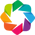

In [17]:
'''
Datashader
'''
import holoviews as hv, colorcet as cc
import datashader as ds
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

'''
밑에 있는 3줄 짜리는 최초 실행 한번만 하고
두번째 실행 부터는 실행 시키면 안된다.
밑에 세줄짜리 코드가 넘파이로 뭐 벡터화 시켜서 
경도, 위도를 웹머케이터 좌표계로 좌표 변환 한다는데 얘는 한번만 해놓으면 된다고 한다. 두번째 부터는 또 변환되기 때문에 오류남
'''
x,y = ds.utils.lnglat_to_meters(CD_df.dLon, CD_df.dLat)
CD_df['dLon'] = x
CD_df['dLat'] = y

map_tiles = hv.element.tiles.EsriImagery().opts(alpha=0.5, width=600, height=600)

points = hv.Points(CD_df, ['dLon', 'dLat'])

ship_traffic = datashade(points, cmap= 'magma', width=600, height=600, x_sampling=1, y_sampling=1)
datashade_visualization = map_tiles * ship_traffic
hv.save(datashade_visualization, 'CD_df_datashade.html')

#datashade_visualization


In [22]:
m = f.Map(location = [126.85461,34.26233])

f.CircleMarker(location = [34.26233, 126.85461], radius = 10).add_to(m)

m